# Оптимизация телемаркетинговой кампании по продаже депозитов (пет-проект)

## Бизнес-контекст
Банк проводит телемаркетинговую кампанию: операторы колл-центра звонят клиентам с предложением открыть срочный вклад.
Текущая стратегия - "массовый обзвон" по доступной базе. Это приводит к высоким затратам на оплату труда операторов и телефонию, а также вызывает раздражение у нецелевых клиентов данного продукта.

**Цель исследования:** найти способы приоритизировать базу для обзвона, чтобы максимизировать прибыль кампании и снизить стоимость привлечения одного клиента.

**Основные метрики:**
* **Conversion Rate (CR)** - конверсия звонка в открытый депозит.
* **Customer Acquisition Cost (CAC)** - стоимость привлечения одного клиента с депозитом.
* **Return on Investment (ROI)** - окупаемость кампании.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("muted")

In [ ]:
bank = pd.read_csv('bank-additional-full.csv', sep=';')
print(f"Размер датасета: {bank.shape}")
bank.tail()

Размер датасета: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


### Предобработка и борьба с утечкой данных

В датасете присутствует колонка duration, которая отражает продолжительность звонка. Перед началом самого анализа эту колонку необходимо удалить, поскольку длительность звонка становится известной только после его завершения.

Цель - научиться прогнозировать успешность звонка до его начала, чтобы не зависеть от переменной, значение которой определяется уже после завершения разговора. Между переменными duration и Y существует сильная положительная корреляция. Например, если клиент соглашается открыть вклад, оператор может потратить больше времени на оформление заявки (длительность звонка будет значительной). В случае, если клиент не желает открывать вклад, звонок будет коротким.

In [ ]:
duplicates_count = bank.duplicated().sum()
print(f"Найдено абсолютных дубликатов: {duplicates_count}")

bank.drop_duplicates(inplace=True)
print("Технические дубликаты удалены")

bank.drop(columns=['duration'], inplace=True)
print("Столбец 'duration' удален")

bank['y_bin'] = (bank['y'] == 'yes').astype(int)

print(f"\nИтоговый размер чистого датасета: {bank.shape}")

Найдено абсолютных дубликатов: 12
Технические дубликаты удалены
Столбец 'duration' удален

Итоговый размер чистого датасета: (41176, 21)


## Оценка базовой unit-экономики
Сколько денег кампания приносит/сжигает сейчас. Введем гипотетические финансовые параметры, пусть:

* **Стоимость одного контакта с клиентом:** 100 руб (зарплата оператора, связь ...)

* **Доход с одного открытого депозита (LTV):** 1500 руб

In [ ]:
cost_per_call = 100
revenue_per_deposit = 1500

total_calls = bank['campaign'].sum()
total_clients = len(bank)
total_deposits = bank['y_bin'].sum()

cr_client = total_deposits / total_clients
cr_call = total_deposits / total_calls

total_cost = total_calls * cost_per_call
total_revenue = total_deposits * revenue_per_deposit
profit = total_revenue - total_cost

if total_deposits > 0:
  cac = total_cost / total_deposits
else:
  cac = 0

print(f"--- Текущая экономика кампании (As-Is) ---")
print(f"\nОхвачено уникальных клиентов: {total_clients:,.0f}")
print(f"Всего совершено звонков: {total_calls:,.0f}")
print(f"Конверсия в покупку (на клиента): {cr_client * 100:.2f}%")
print(f"Конверсия в покупку (на звонок): {cr_call * 100:.2f}%")
print(f"\nПотрачено на прозвон: {total_cost:,.0f} руб")
print(f"Заработано с депозитов: {total_revenue:,.0f} руб")
print(f"Прибыль: {profit:,.0f} руб (ROI: {profit/total_cost*100:.2f}%)")
print(f"Фактический CAC: {cac:,.0f} руб")

--- Текущая экономика кампании (As-Is) ---

Охвачено уникальных клиентов: 41,176
Всего совершено звонков: 105,735
Конверсия в покупку (на клиента): 11.27%
Конверсия в покупку (на звонок): 4.39%

Потрачено на прозвон: 10,573,500 руб
Заработано с депозитов: 6,958,500 руб
Прибыль: -3,615,000 руб (ROI: -34.19%)
Фактический CAC: 2,279 руб


При текущих вводных кампания глубоко убыточна. CAC (2279 руб) превышает доход с депозита (1500 руб).

Нужно сокращать количество пустых звонков и повышать CR.

## Разведочный анализ
Чтобы построить профиль идеального клиента и оптимизировать обзвон, проанализируем данные по смысловым блокам:
1. **Социальный профиль:** возраст, профессия, образование.
2. **Финансовый статус:** наличие кредитов и ипотеки.
3. **Каналы и сезонность:** тип связи, месяцы, дни недели.
4. **История и назойливость:** количество звонков и успех прошлых кампаний.

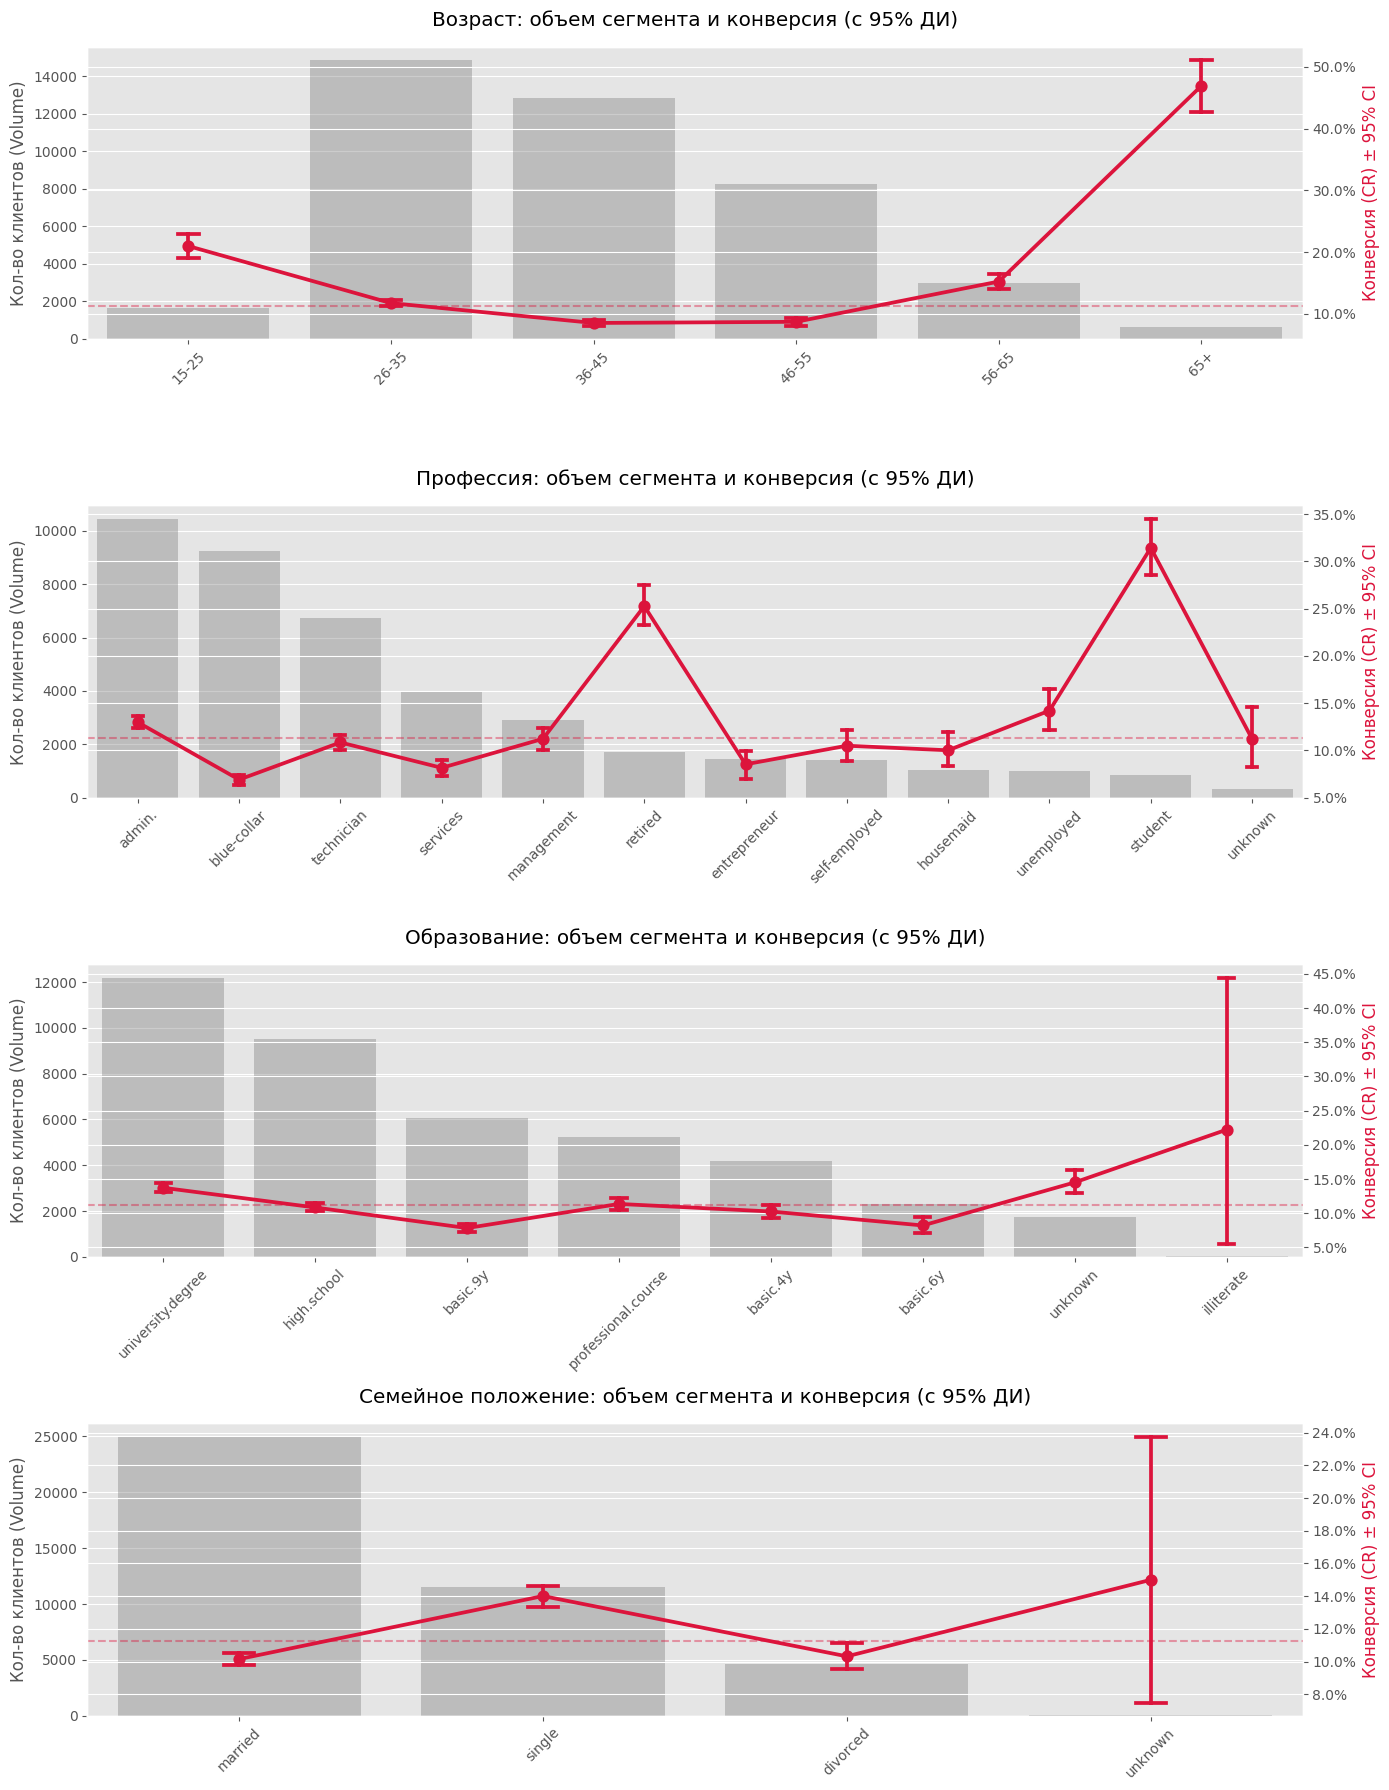

In [ ]:
bank['age_bin'] = pd.cut(bank['age'], bins=[15, 25, 35, 45, 55, 65, 100], labels=['15-25', '26-35', '36-45', '46-55', '56-65', '65+'])

def plot_volume_and_cr_with_ci(data, col, ax, title):
    volume_data = data[col].value_counts().reset_index()
    volume_data.columns = [col, 'volume']

    if col != 'age_bin':
        order = volume_data.sort_values('volume', ascending=False)[col].tolist()
    else:
        order = volume_data.sort_values(col)[col].tolist()

    sns.barplot(data=volume_data, x=col, y='volume', ax=ax, color='gray', alpha=0.4, order=order)
    ax.set_ylabel('Кол-во клиентов (Volume)')
    ax.set_xlabel('')
    ax.set_title(title, pad=15)
    ax.tick_params(axis='x', rotation=45)

    ax2 = ax.twinx()
    sns.pointplot(data=data, x=col, y='y_bin', ax=ax2, color='crimson', markers='o',
                  order=order, errorbar=('ci', 95), capsize=0.1)
    ax2.set_ylabel('Конверсия (CR) ± 95% CI', color='crimson')

    ax2.axhline(cr_client, color='crimson', linestyle='--', alpha=0.4)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

fig, axes = plt.subplots(4, 1, figsize=(14, 18))

plot_volume_and_cr_with_ci(bank, 'age_bin', axes[0], 'Возраст: объем сегмента и конверсия (с 95% ДИ)')
plot_volume_and_cr_with_ci(bank, 'job', axes[1], 'Профессия: объем сегмента и конверсия (с 95% ДИ)')
plot_volume_and_cr_with_ci(bank, 'education', axes[2], 'Образование: объем сегмента и конверсия (с 95% ДИ)')
plot_volume_and_cr_with_ci(bank, 'marital', axes[3], 'Семейное положение: объем сегмента и конверсия (с 95% ДИ)')

plt.tight_layout()
plt.show()

**Вывод по социальному профилю клиента:**
благодаря 95% доверительным интервалам на графиках мы можем делать обоснованные выводы о значимости конверсий до проведения стат тестов:
1. **Возраст:** у молодежи (15-25) и пенсионеров (65+) очень широкие доверительные интервалы, что логично из-за малого объема этих групп. Но даже нижняя граница их конверсии (около 18% и 40% соответственно) находится сильно выше верхней границы конверсии массового сегмента 26-45 лет. Разница статистически значима.
2. **Профессии:** группа student имеет высокую дисперсию, но их конверсия гарантированно выше, чем у самой массовой группы admin А вот разница между admin и technician статистически не значима - их доверительные интервалы пересекаются, по сути это один и тот же уровень конверсии (11-12%). Группа blue-collar - аутсайдеры, их верхняя граница конверсии даже не дотягивает до средних значений по банку.
3. **Образование:** сегмент university.degree значимо превосходит сегмент high.school и basic.9y. Большой интервал у illiterate (безграмотные) говорит о том, что таких людей в выборке единицы, и их 20% конверсии - просто статистический шум, на который бизнесу не нужно обращать внимание.
4. **Семейное положение:** холостые (single) клиенты конвертируются статистически значимо лучше, чем женатые/замужние (married) и разведенные (divorced).

/tmp/ipython-input-768/717220653.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bank, x='housing', y='y_bin', ax=axes[0], palette='Set2')
/tmp/ipython-input-768/717220653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bank, x='loan', y='y_bin', ax=axes[1], palette='Set2')


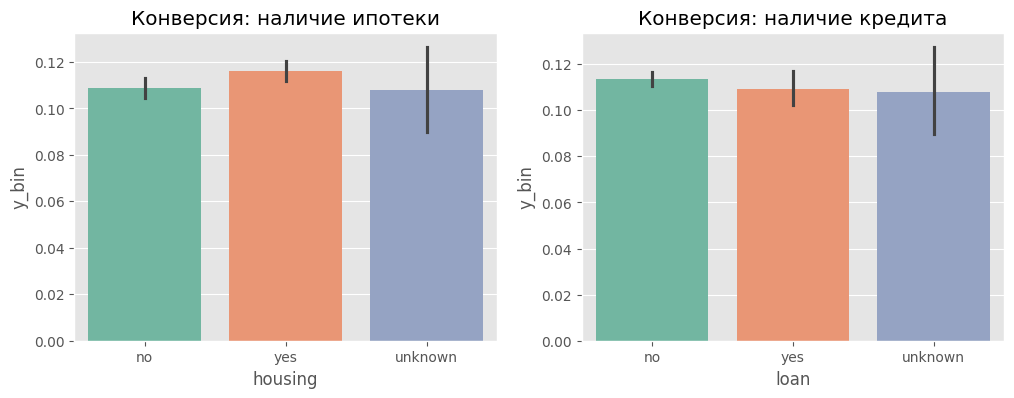

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=bank, x='housing', y='y_bin', ax=axes[0], palette='Set2')
axes[0].set_title('Конверсия: наличие ипотеки')

sns.barplot(data=bank, x='loan', y='y_bin', ax=axes[1], palette='Set2')
axes[1].set_title('Конверсия: наличие кредита')

plt.show()

**Вывод по финансам:** наличие ипотеки или потребительского кредита практически не влияет на желание открыть вклад (разница менее 0.5 п.п.). Мы не будем использовать эти признаки для приоритизации обзвона.

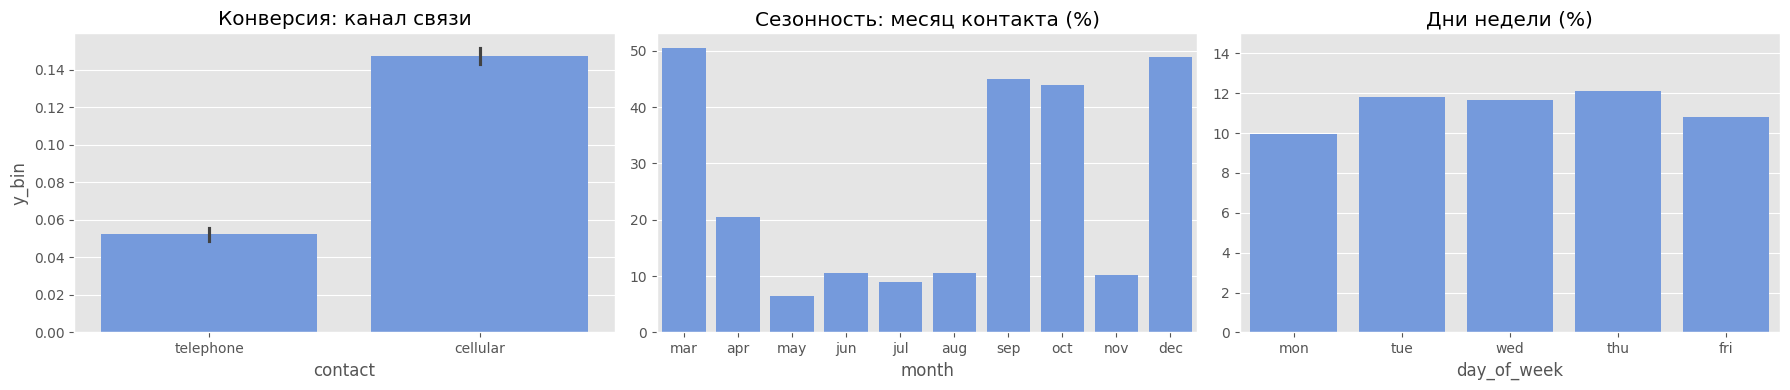

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(data=bank, x='contact', y='y_bin', ax=axes[0], color='cornflowerblue')
axes[0].set_title('Конверсия: канал связи')

months_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_cr = bank.groupby('month')['y_bin'].mean().reindex(months_order) * 100
sns.barplot(x=month_cr.index, y=month_cr.values, ax=axes[1], color='cornflowerblue')
axes[1].set_title('Сезонность: месяц контакта (%)')

days_order = ['mon', 'tue', 'wed', 'thu', 'fri']
day_cr = bank.groupby('day_of_week')['y_bin'].mean().reindex(days_order) * 100
sns.barplot(x=day_cr.index, y=day_cr.values, ax=axes[2], color='cornflowerblue')
axes[2].set_title('Дни недели (%)')
axes[2].set_ylim(0, 15)

plt.tight_layout()
plt.show()

**Вывод по времени и каналам:**
1. **Канал:** мобильные телефоны конвертируются почти в 3 раза лучше стационарных.
2. **Сезонность** ярко выражена. Весна (март, апрель) и осень (сентябрь, октябрь, декабрь) дают хороший результат. Летние месяцы (май-август) провальные.
3. **День недели:** не влияет на успех.

/tmp/ipython-input-768/289424594.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=poutcome_cr.index, y=poutcome_cr.values, ax=axes[0], palette='autumn')


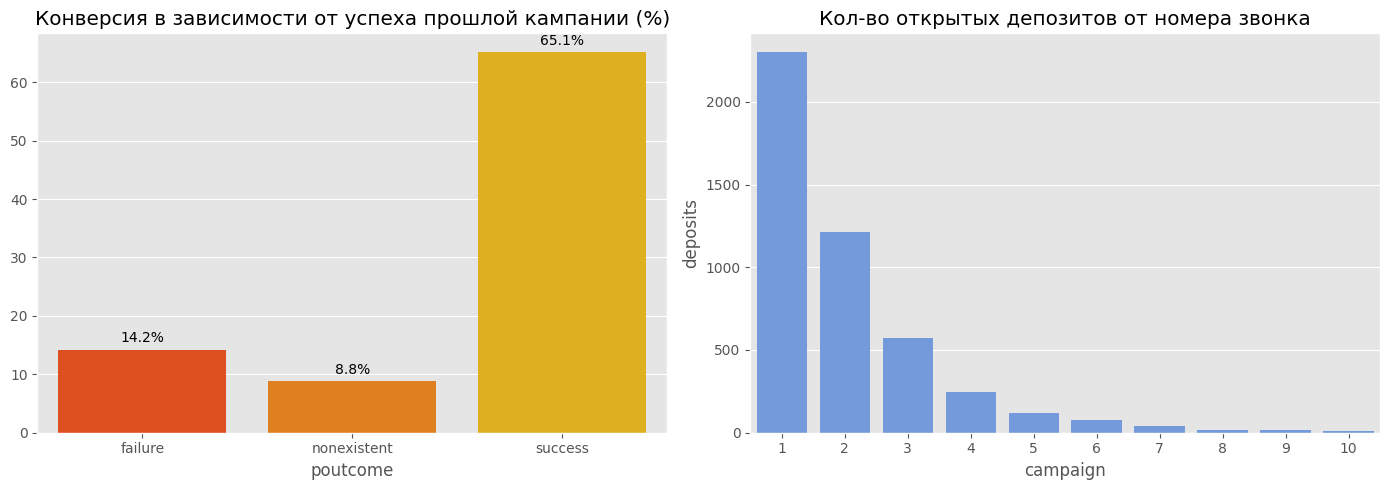

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

poutcome_cr = bank.groupby('poutcome')['y_bin'].mean() * 100
sns.barplot(x=poutcome_cr.index, y=poutcome_cr.values, ax=axes[0], palette='autumn')
axes[0].set_title('Конверсия в зависимости от успеха прошлой кампании (%)')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', padding=3)

campaign_stats = bank.groupby('campaign').agg(deposits=('y_bin', 'sum')).reset_index()
sns.barplot(data=campaign_stats[campaign_stats['campaign'] <= 10], x='campaign', y='deposits', ax=axes[1], color='cornflowerblue')
axes[1].set_title('Кол-во открытых депозитов от номера звонка')

plt.tight_layout()
plt.show()

**Вывод по истории:**
1. **Теплая база:** клиенты, которые согласились на предложение в прошлой кампании (success), конвертируются более 65%.
2. **Назойливость:** абсолютное большинство продаж закрывается за 1-3 звонка. Дальнейшие попытки дозвониться сжигают деньги.

## Статистическая проверка гипотез
Выберем 4 самых сильных визуальных инсайта и докажем с помощью Z-теста для долей, что разница статистически значима, а не является случайным выбросом на нашей выборке.

H1 гипотезы:
1. **Аудитория:** конверсия "горячих" сегментов (студенты и пенсионеры) значимо выше, чем у самой проблемной группы (рабочие/blue-collar).
2. **Канал связи:** звонки на мобильные телефоны конвертируются значимо лучше, чем на стационарные.
3. **Лояльность:** клиенты с успешным опытом в прошлой кампании открывают вклады значимо чаще, чем "холодные" клиенты.
4. **Граница назойливости:** эффективность звонков с 1-го по 3-й значимо выше, чем попытки дозвониться 4 раза и более.

In [ ]:
def run_ztest(group_a, group_b, name_a, name_b):
    successes = np.array([group_a.sum(), group_b.sum()])
    nobs = np.array([group_a.count(), group_b.count()])

    stat, pval = proportions_ztest(successes, nobs)
    cr_a = (successes[0] / nobs[0]) * 100
    cr_b = (successes[1] / nobs[1]) * 100

    print(f"[{name_a} ({cr_a:.1f}%)]  VS  [{name_b} ({cr_b:.1f}%)]")
    print(f"P-value: {pval:.10e} -> {'Значимо' if pval < 0.05 else 'Не значимо'}\n")

print("--- РЕЗУЛЬТАТЫ СТАТИСТИЧЕСКИХ ТЕСТОВ ---\n")

hot_socdem = bank[bank['job'].isin(['student', 'retired'])]['y_bin']
blue_collar = bank[bank['job'] == 'blue-collar']['y_bin']
run_ztest(hot_socdem, blue_collar, "Студенты и пенсионеры", "Рабочие")

mobile = bank[bank['contact'] == 'cellular']['y_bin']
phone = bank[bank['contact'] == 'telephone']['y_bin']
run_ztest(mobile, phone, "Мобильные телефоны", "Стационарные")

past_success = bank[bank['poutcome'] == 'success']['y_bin']
past_nonexistent = bank[bank['poutcome'] == 'nonexistent']['y_bin']
run_ztest(past_success, past_nonexistent, "Успех в прошлом", "Новые клиенты")

calls_1_to_3 = bank[bank['campaign'] <= 3]['y_bin']
calls_4_plus = bank[bank['campaign'] > 3]['y_bin']
run_ztest(calls_1_to_3, calls_4_plus, "Звонки 1-3", "Звонки 4 и более")

--- РЕЗУЛЬТАТЫ СТАТИСТИЧЕСКИХ ТЕСТОВ ---

[Студенты и пенсионеры (27.3%)]  VS  [Рабочие (6.9%)]
P-value: 9.3456653329e-185 -> Значимо

[Мобильные телефоны (14.7%)]  VS  [Стационарные (5.2%)]
P-value: 1.0679116189e-189 -> Значимо

[Успех в прошлом (65.1%)]  VS  [Новые клиенты (8.8%)]
P-value: 0.0000000000e+00 -> Значимо

[Звонки 1-3 (12.2%)]  VS  [Звонки 4 и более (7.3%)]
P-value: 2.0150578369e-34 -> Значимо



## Продуктовое решение и дизайн A/B теста
На основе глубокого анализа мы формируем To-Be стратегию (новую систему маршрутизации звонков) для колл-центра. Разделим правила на стратегические (когда звонить) и тактические (кому звонить).

**Тайминг:**
* Основные бюджеты на телемаркетинг выделяются в сезоны высокой конверсии (весна: март-апрель; осень-зима: сентябрь, октябрь, декабрь).
* В летние месяцы (май-август) интенсивность массового обзвона снижается до минимума.

**Тактические правила приоритизации базы:**
1. **Максимальный приоритет:** клиенты со статусом poutcome = success забираются в работу в первый же день кампании независимо от их возраста и профессии.
2. **Высокий приоритет:** сегменты с высокой конверсией (студенты и пенсионеры). Звонки осуществляются строго на мобильные телефоны.
3. **Низкий приоритет:** клиенты рабочих специальностей и со стационарными телефонами. Обзваниваются по остаточному принципу, если операторы простаивают.

**Фильтр отсечения:** не более 3-х звонков одному клиенту в рамках одной кампании. На 4-й раз клиент навсегда исключается из текущего пула обзвона.

**Ожидания:** рост конверсии на клиента с базовых 11.27% до 14.0%, при резком падении затрат (благодаря отсечению звонков 4+ и "плохих" сегментов).

In [ ]:
#AS-IS
calls_as_is = bank['campaign'].sum()
deps_as_is = bank['y_bin'].sum()
cost_as_is = calls_as_is * cost_per_call
rev_as_is = deps_as_is * revenue_per_deposit
profit_as_is = rev_as_is - cost_as_is
cac_as_is = cost_as_is / deps_as_is if deps_as_is > 0 else 0

#TO-BE
mask_tier1 = (bank['poutcome'] == 'success')
bad_jobs = ['blue-collar', 'services', 'entrepreneur', 'housemaid']
mask_tier2 = (bank['contact'] == 'cellular') & (~bank['job'].isin(bad_jobs))

df_tobe = bank[mask_tier1 | mask_tier2].copy()
clients_tobe = len(df_tobe)

df_tobe['tobe_calls'] = df_tobe['campaign'].apply(lambda x: x if x <= 3 else 3)
df_tobe['tobe_deposits'] = df_tobe.apply(lambda row: row['y_bin'] if row['campaign'] <= 3 else 0, axis=1)

calls_tobe = df_tobe['tobe_calls'].sum()
deps_tobe = df_tobe['tobe_deposits'].sum()
cost_tobe = calls_tobe * cost_per_call
rev_tobe = deps_tobe * revenue_per_deposit
profit_tobe = rev_tobe - cost_tobe
cac_tobe = cost_tobe / deps_tobe if deps_tobe > 0 else 0
roi_tobe = (profit_tobe / cost_tobe) * 100
cr_tobe = deps_tobe / clients_tobe

comparison = pd.DataFrame({
    'Метрика': [
        'Уникальных клиентов в обзвоне',
        'Всего сделано звонков',
        'Открытые депозиты',
        'Затраты на прозвон',
        'Доход с депозитов',
        'Чистая прибыль',
        'Конверсия',
        'CAC',
        'ROI'
    ],
    'AS-IS (Было)': [
        f"{len(bank):,.0f}",
        f"{calls_as_is:,.0f}",
        f"{deps_as_is:,.0f}",
        f"{cost_as_is:,.0f} руб",
        f"{rev_as_is:,.0f} руб",
        f"{profit_as_is:,.0f} руб",
        f"{(deps_as_is/len(bank))*100:.1f}%",
        f"{cac_as_is:,.0f} руб",
        f"{(profit_as_is/cost_as_is)*100:.1f}%"
    ],
    'TO-BE (Стало)': [
        f"{clients_tobe:,.0f}",
        f"{calls_tobe:,.0f}",
        f"{deps_tobe:,.0f}",
        f"{cost_tobe:,.0f} руб",
        f"{rev_tobe:,.0f} руб",
        f"{profit_tobe:,.0f} руб",
        f"{cr_tobe*100:.1f}%",
        f"{cac_tobe:,.0f} руб",
        f"{roi_tobe:.1f}%"
    ]
})

comparison

,Метрика,AS-IS (Было),TO-BE (Стало)
0,Уникальных клиентов в обзвоне,"41,176","17,573"
1,Всего сделано звонков,"105,735","32,302"
2,Открытые депозиты,"4,639","2,831"
3,Затраты на прозвон,"10,573,500 руб","3,230,200 руб"
4,Доход с депозитов,"6,958,500 руб","4,246,500 руб"
5,Чистая прибыль,"-3,615,000 руб","1,016,300 руб"
6,Конверсия,11.3%,16.1%
7,CAC,"2,279 руб","1,141 руб"
8,ROI,-34.2%,31.5%


Применив новые правила скоринга, мы сокращаем объем работы колл-центра на 70% (с 105 тыс звонков до 32 тыс).
Да, в абсолютных цифрах мы откроем меньше вкладов (2831 против 4639), тк отсекаем часть базы. Но качество этих продаж кардинально меняется:
* **CAC** падает в 2 раза: с 2279 руб. до 1141 руб.
* **Прибыль** вырастает с убытка в 3.6 млн руб. до чистой прибыли в **+1.01 млн руб**.
* **Конверсия** вырастает с 11.3% до 16.1%.

Именно эти цифры мы возьмем за основу для нашего продуктового A/B теста.

In [ ]:
baseline_conversion = cr_client
expected_conversion = 0.161

effect_size = sms.proportion_effectsize(baseline_conversion, expected_conversion)

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print(f"Для проверки новой стратегии в A/B тесте необходимо выделить:")
print(f"Контрольная группа: {int(np.ceil(sample_size))} клиентов")
print(f"Тестовая группа: {int(np.ceil(sample_size))} клиентов")

Для проверки новой стратегии в A/B тесте необходимо выделить:
Контрольная группа: 788 клиентов
Тестовая группа: 788 клиентов


### Методология A/B теста

Чтобы результаты теста были достоверными и бизнес мог безопасно принять решение о раскатке новой стратегии, зафиксируем следующие параметры проведения:

**1. Метод разделения трафика:** будем использовать стратифицированное сэмплирование по признакам poutcome (история клиента) и job (профессия).
Обычный рандом может случайно запихнуть в одну из групп больше клиентов из "хороших" категорий, что даст ложноположительный результат. Стратификация гарантирует, что в тесте и контроле будет абсолютно идентичный процент лояльных клиентов, студентов, рабочих...

**2. Оценка длительности теста:** необходимо пропустить через тест около 1600 уникальных клиентов (по 788 в тестовую и контрольную ветки).

Исходя из пропускной способности колл-центра, мы могли бы набрать эту выборку за 1-2 дня. Но мы зафиксируем длительность теста на 1 полной неделе.

Запуск теста на 1-2 дня несет операционные риски: в этот день может работать самая сильная/слабая смена операторов, может произойти технический сбой или краткосрочная внешняя аномалия. Растягивание теста на полную неделю это стандарт, который гарантирует валидность результатов.

**3. Иерархия метрик**

* **Первичные метрики:**
    * **ROI:** ожидаем выход из отрицательной зоны в +30%.
    * **CAC:** ожидаем снижение стоимости клиента в 2 раза (с 2200 руб. до 1100 руб.).
* **Прокси:**
    * **Client CR:** Ожидаем рост с 11.3% до 16.1%.
    * **Среднее кол-во звонков на клиента:** ожидаем резкое снижение в тестовой выборке из-за жесткого лимита (не более 3 звонков).
* **Health-check:**
    * **Уровень негатива:** отслеживаем процент клиентов, бросивших трубку или попросивших "больше никогда не звонить". Ожидаем снижение этого показателя в тестовой выборке за счет снижения назойливости.